<a href="https://colab.research.google.com/github/AbdelnasserMostafa/-myproject/blob/master/Copy_of_Google_Machine_Learning_With_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.13.1


# Introduction to Pandas

In [ ]:
from __future__ import print_function
import pandas as pd
pd.__version__

'0.24.2'

In [ ]:
pd.Series(['San Francisco', 'San jose', 'Sacramento'])

0    San Francisco
1         San jose
2       Sacramento
dtype: object

In [ ]:
city_names = pd.Series(['San Francisco', 'San Jose', 'Sacramento'])
population = pd.Series([852469, 1015785, 485199])

pd.DataFrame({ 'City name': city_names, 'Population': population })

,City name,Population
0,San Francisco,852469
1,San Jose,1015785
2,Sacramento,485199


In [ ]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b5c4d90b8>]],
      dtype=object)

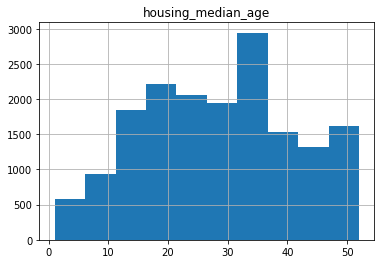

In [ ]:
california_housing_dataframe.hist('housing_median_age')

## Accessing Data

You can access `DataFrame` data using familiar Python dict/list operations:

In [ ]:
cities = pd.DataFrame({'City name': city_names, 'Population': population })
print(type(cities['City name']))
cities['City name']

<class 'pandas.core.series.Series'>


0    San Francisco
1         San Jose
2       Sacramento
Name: City name, dtype: object

In [ ]:
print(type(cities['City name'][1]))
cities['City name'][1]

<class 'str'>


'San Jose'

In [ ]:
print(type(cities[0:2]))
cities[0:2]

<class 'pandas.core.frame.DataFrame'>


,City name,Population
0,San Francisco,852469
1,San Jose,1015785


## Manipulating Data

You may apply Python's basic arithmetic operations to `Series`. For example:

In [ ]:
population / 1000

0     852.469
1    1015.785
2     485.199
dtype: float64

[NumPy](http://www.numpy.org/) is a popular toolkit for scientific computing. *pandas* `Series` can be used as arguments to most NumPy functions:

In [ ]:
import numpy as np
np.log(population)

0    13.655892
1    13.831172
2    13.092314
dtype: float64

For more complex single-column transformations, you can use `Series.apply`. Like the Python [map function](https://docs.python.org/2/library/functions.html#map), 
`Series.apply` accepts as an argument a [lambda function](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions), which is applied to each value.

The example below creates a new `Series` that indicates whether `population` is over one million:

In [ ]:
population.apply(lambda val: val > 1000000)

0    False
1     True
2    False
dtype: bool

Modifying `DataFrames` is also straightforward. For example, the following code adds two `Series` to an existing `DataFrame`:

In [ ]:
cities['Area square miles'] = pd.Series([46.87, 176.53, 97.92])
cities['Population density'] = cities['Population'] / cities['Area square miles']
cities

,City name,Population,Area square miles,Population density
0,San Francisco,852469,46.87,18187.945381
1,San Jose,1015785,176.53,5754.177760
2,Sacramento,485199,97.92,4955.055147


# First Steps with TensorFlow

**Learning Objectives:**
  * Learn fundamental TensorFlow concepts
  * Use the `LinearRegressor` class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improve the accuracy of a model by tuning its hyperparameters
  
  The [data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California.
  
  ## Setup
In this first cell, we'll load the necessary libraries.

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

In [ ]:
# next we will load our dataset
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [ ]:
california_housing_dataframe = california_housing_dataframe.reindex(
  np.random.permutation(california_housing_dataframe.index))

california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8682,-118.6,34.2,13.0,8327.0,1849.0,4126.0,1773.0,3.7,189.8
3386,-117.9,33.7,25.0,1799.0,557.0,3416.0,538.0,3.0,163.5
3368,-117.9,33.9,25.0,1234.0,351.0,507.0,285.0,2.3,225.0
88,-115.6,32.8,29.0,1207.0,301.0,804.0,288.0,2.0,61.1
5865,-118.2,34.0,41.0,679.0,184.0,788.0,185.0,2.1,165.3
...,...,...,...,...,...,...,...,...,...
5218,-118.1,33.8,37.0,4365.0,926.0,1661.0,868.0,5.3,360.7
1236,-117.1,33.1,17.0,1149.0,182.0,702.0,192.0,5.6,168.4
5397,-118.2,33.9,29.0,2690.0,659.0,1747.0,617.0,3.4,198.2
16113,-122.5,37.8,52.0,3193.0,688.0,2099.0,681.0,3.9,402.9


## Examine the Data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column: count of examples, mean, standard deviation, max, min, and various quantiles.

In [ ]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Build the First Model

In this exercise, we'll try to predict `median_house_value`, which will be our label (sometimes also called a target). We'll use `total_rooms` as our input feature.

**NOTE:** Our data is at the city block level, so this feature represents the total number of rooms in that block.

To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

## Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

To start, we're going to use just one numeric input feature, `total_rooms`. The following code pulls the `total_rooms` data from our `california_housing_dataframe` and defines the feature column using `numeric_column`, which specifies its data is numeric:

In [ ]:
# Define the input featuer: total_rooms.
my_feature = california_housing_dataframe[['total_rooms']]

# Configure a numeric feature column for total_rooms
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

**NOTE:** The shape of our `total_rooms` data is a one-dimensional array (a list of the total number of rooms for each block). This is the default shape for `numeric_column`, so we don't have to pass it as an argume

### Step 2: Define the Target

Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`:

In [ ]:
# Define the label
targets = california_housing_dataframe['median_house_value']

## Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [ ]:
# Use gradient descent as the optimizer for training the model
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
  feature_columns = feature_columns,
  optimizer = my_optimizer
)

## Step 4: Define the input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Step 6: Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [ ]:
# Ceate an input function for predictions.
# Note: Since we're making just one prediction for each example, we don;t
# need to repeat or shuffle the data herel
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# format predictions as a NumPy array, so we can calculate error metrics
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print('Mean Squared Error (on training data): %0.3f' % mean_squared_error)
print('Root Mean Squared Error (on training data): %0.3f' % root_mean_squared_error)

Mean Squared Error (on training data): 56425.111
Root Mean Squared Error (on training data): 237.540


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [ ]:
min_house_value = california_housing_dataframe['median_house_value'].min()
max_house_value = california_housing_dataframe['median_house_value'].max()
min_max_difference = max_house_value - min_house_value

print('Min. Median House Value: %0.3f' % min_house_value)
print('Max. Median House Value: %0.3f' % max_house_value)
print('Difference between Min. and Max: %0.3f' % min_max_difference)
print('Root Mean Squared Error: %0.3f' % root_mean_squared_error)


Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max: 485.002
Root Mean Squared Error: 237.540


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [ ]:
calibration_data = pd.DataFrame()
calibration_data['Predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,Predictions,targets
count,17000.0,17000.0
mean,0.0,207.3
std,0.0,116.0
min,0.0,15.0
25%,0.0,119.4
50%,0.0,180.4
75%,0.0,265.0
max,0.0,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [ ]:
sample = california_housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

In [ ]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

ValueError: ignored

## Tweak the Model Hyperparameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time.  This is another way to see how things converge.

In [ ]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## Task 1:  Achieve an RMSE of 180 or Below

Tweak the model hyperparameters to improve loss and better match the target distribution.
If, after 5 minutes or so, you're having trouble beating a RMSE of 180, check the solution for a possible combination.

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


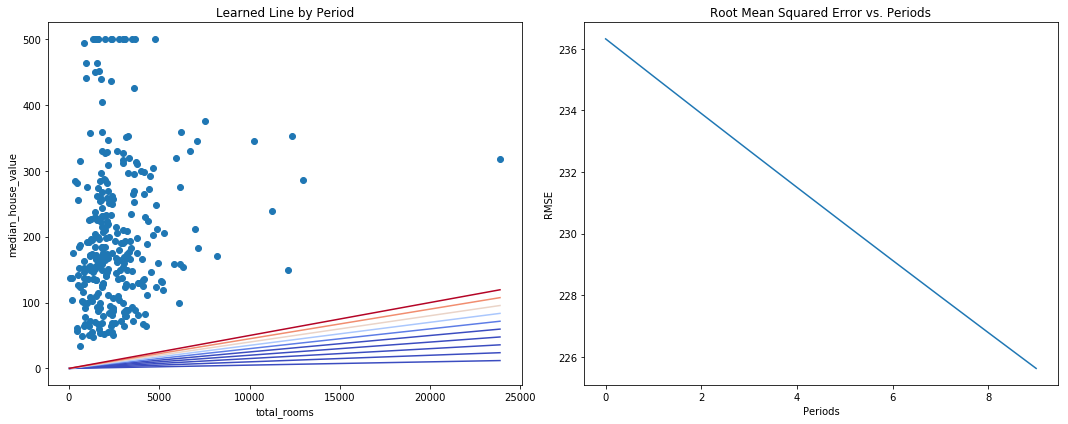

In [ ]:
train_model(
  learning_rate=0.00001,
  steps=100,
  batch_size=1
)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.29
  period 05 : 180.27
  period 06 : 174.79
  period 07 : 171.07
  period 08 : 168.84
  period 09 : 167.30
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,116.9,207.3
std,96.4,116.0
min,0.1,15.0
25%,64.6,119.4
50%,94.0,180.4
75%,139.3,265.0
max,1676.8,500.0


Final RMSE (on training data): 167.30


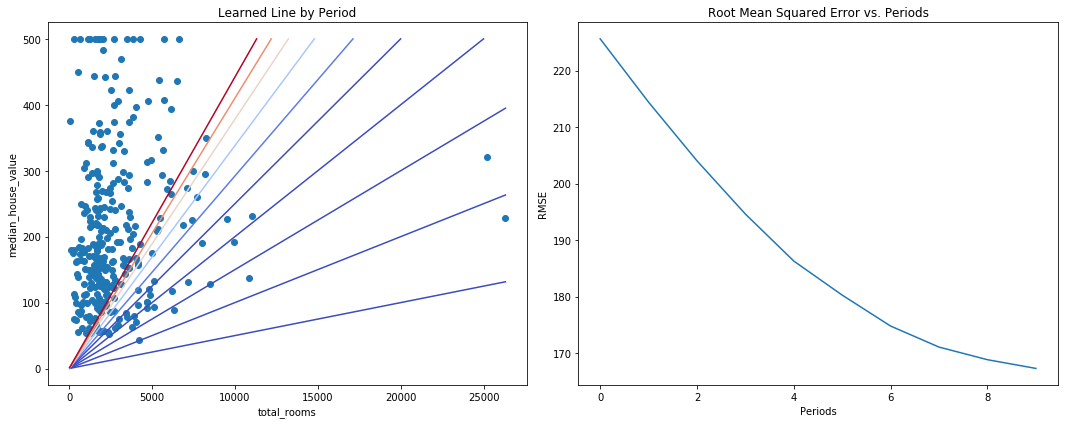

In [ ]:
train_model(
  learning_rate=0.00002,
  steps = 500,
  batch_size = 5
)

### Is There a Standard Heuristic for Model Tuning?

This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

## Task 2: Try a Different Feature

See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

Don't take more than 5 minutes on this portion.

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.84
  period 02 : 205.43
  period 03 : 196.75
  period 04 : 189.94
  period 05 : 184.91
  period 06 : 181.10
  period 07 : 178.49
  period 08 : 176.92
  period 09 : 176.10
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,118.1,207.3
std,94.8,116.0
min,0.2,15.0
25%,65.3,119.4
50%,96.4,180.4
75%,142.2,265.0
max,2947.3,500.0


Final RMSE (on training data): 176.10


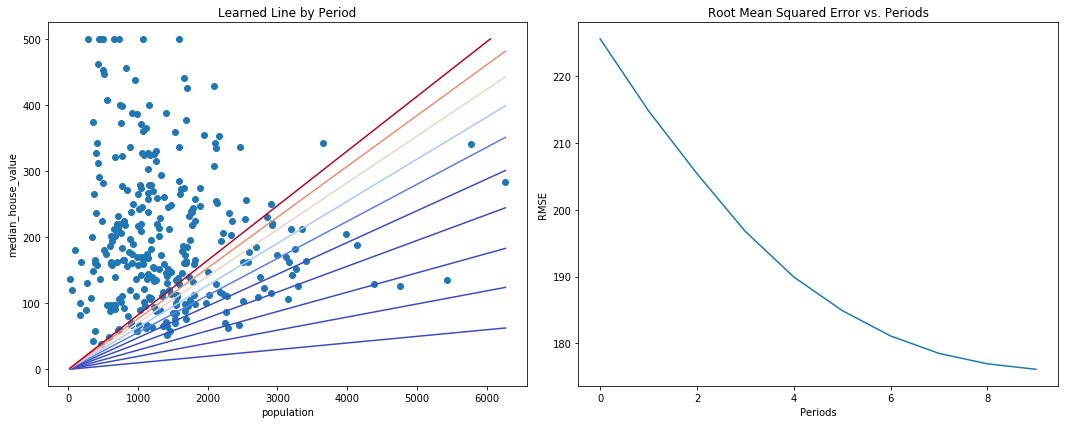

In [ ]:
train_model(
  learning_rate = 0.00002,
  steps = 1000,
  batch_size = 5,
  input_feature = 'population'
)

## Synthetic Features and Outliers 

**Learning Objectives:**
  * Create a synthetic feature that is the ratio of two other features
  * Use this new feature as an input to a linear regression model
  * Improve the effectiveness of the model by identifying and clipping (removing) outliers out of the input data
  
  Let's revisit our model from the previous First Steps with TensorFlow exercise. 

First, we'll import the California housing data into a *pandas* `DataFrame`:

In [ ]:
# Setup

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13808,-122.0,37.2,31.0,1574.0,193.0,551.0,191.0,10.2,500.0
3229,-117.9,34.1,40.0,1304.0,280.0,607.0,256.0,2.6,209.5
13411,-121.9,37.3,46.0,2451.0,472.0,1163.0,448.0,4.9,225.8
646,-117.0,33.0,28.0,922.0,107.0,314.0,97.0,8.5,342.3
12341,-121.5,38.6,24.0,938.0,275.0,508.0,253.0,1.6,32.5
...,...,...,...,...,...,...,...,...,...
9975,-119.8,36.7,29.0,1745.0,441.0,1530.0,391.0,1.6,44.4
5718,-118.2,34.1,41.0,2090.0,530.0,2043.0,537.0,2.0,144.2
11605,-121.3,38.0,46.0,1026.0,330.0,1109.0,333.0,1.3,63.3
11337,-121.2,38.9,8.0,4114.0,710.0,2268.0,716.0,4.4,139.4


In [ ]:
# Next, we'll set up our input function, and define the function for model training:

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  '''Trains a linear regression model of one feature
  
  Args:
    features: pandas DataFrame of features
    targetsL: pandas DataFrame of targets
    batch_size: Size of batches to be passed to the model
    shuffle: True or False. Wheter to shuffle the data.
    num_epochs: Number of epochs for which data should be repeated. None = repeate indefinitely
    Returns: Tuple of (features, labels) for next data batch
   '''
  
  # Convert pandas data into a dict of np arrays.
  features = {key:np.array(value) for key, value in dict(features).items()}
  
  # Construct a dataset, and configure batching/repeating.
  ds = Dataset.from_tensor_slices((features, targets))  # warning: 2GB limit
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  # Shuffle the data, if specified
  if shuffle:
    ds = ds.shuffle(buffer_size = 10000)
    
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [ ]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

## Task 1: Try a Synthetic Feature

Both the `total_rooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another? We can explore how block density relates to median house value by creating a synthetic feature that's a ratio of `total_rooms` and `population`.

In the cell below, create a feature called `rooms_per_person`, and use that as the `input_feature` to `train_model()`.

What's the best performance you can get with this single feature by tweaking the learning rate? (The better the performance, the better your regression line should fit the data, and the lower
the final RMSE should be.)

**NOTE**: You may find it helpful to add a few code cells below so you can try out several different learning rates and compare the results. To add a new code cell, hover your cursor directly below the center of this cell, and click **CODE**.

Training model...
RMSE (on training data):
  period 00 : 212.75
  period 01 : 189.68
  period 02 : 169.05
  period 03 : 152.29
  period 04 : 140.03
  period 05 : 133.00
  period 06 : 130.85
  period 07 : 130.94
  period 08 : 132.27
  period 09 : 132.69
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.9,207.3
std,92.5,116.0
min,45.6,15.0
25%,164.6,119.4
50%,197.8,180.4
75%,226.0,265.0
max,4412.5,500.0


Final RMSE (on training data): 132.69


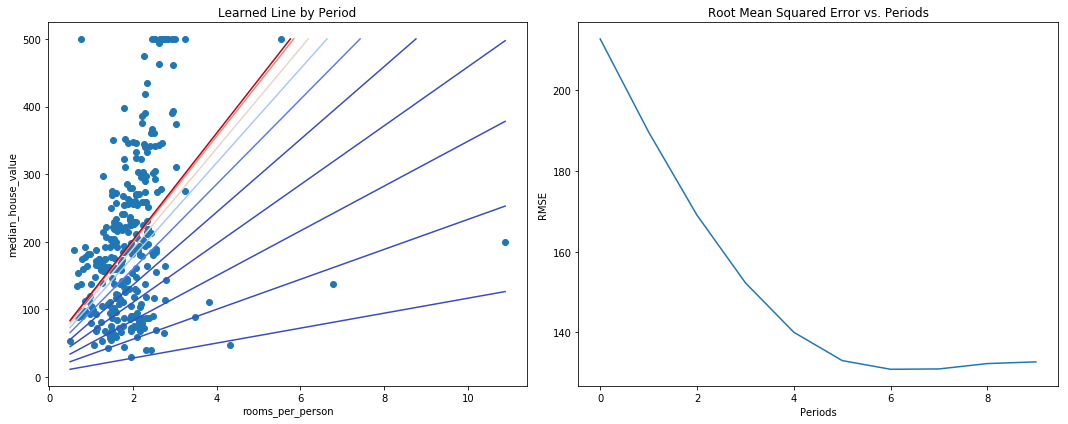

In [ ]:
#
# YOUR CODE HERE
#
california_housing_dataframe['rooms_per_person'] = (
  california_housing_dataframe['total_rooms'] / california_housing_dataframe['population'])

calibration_data = train_model(
    learning_rate = 0.05,
    steps = 500,
    batch_size = 5,
    input_feature = 'rooms_per_person')


## Task 2: Identify Outliers

We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.

Use Pyplot's [`scatter()`](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) to create a scatter plot of predictions vs. targets, using the rooms-per-person model you trained in Task 1.

Do you see any oddities?  Trace these back to the source data by looking at the distribution of values in `rooms_per_person`.

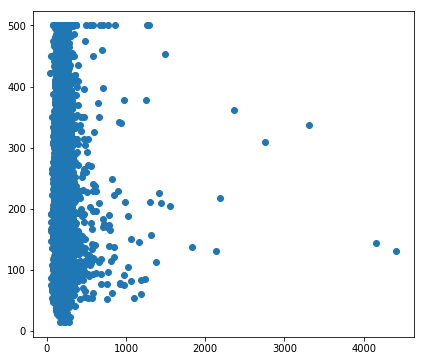

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.scatter(calibration_data['predictions'], calibration_data['targets'])

The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

If we plot a histogram of `rooms_per_person`, we find that we have a few outliers in our input data:

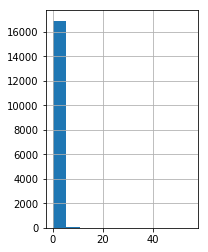

In [ ]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe['rooms_per_person'].hist()

## Task 3: Clip Outliers

See if you can further improve the model fit by setting the outlier values of `rooms_per_person` to some reasonable minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas `Series`:

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

The above `clipped_feature` will have no values less than `0`.

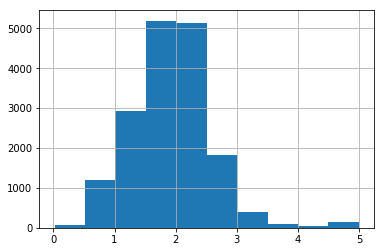

In [ ]:
california_housing_dataframe['rooms_per_person'] = (
  california_housing_dataframe['rooms_per_person']).apply(lambda x: min(x, 5))

_= california_housing_dataframe['rooms_per_person'].hist()

Training model...
RMSE (on training data):
  period 00 : 212.81
  period 01 : 189.08
  period 02 : 166.73
  period 03 : 147.38
  period 04 : 131.99
  period 05 : 119.75
  period 06 : 112.34
  period 07 : 109.55
  period 08 : 108.68
  period 09 : 107.90
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.9,207.3
std,52.9,116.0
min,45.7,15.0
25%,167.1,119.4
50%,201.0,180.4
75%,229.8,265.0
max,447.9,500.0


Final RMSE (on training data): 107.90


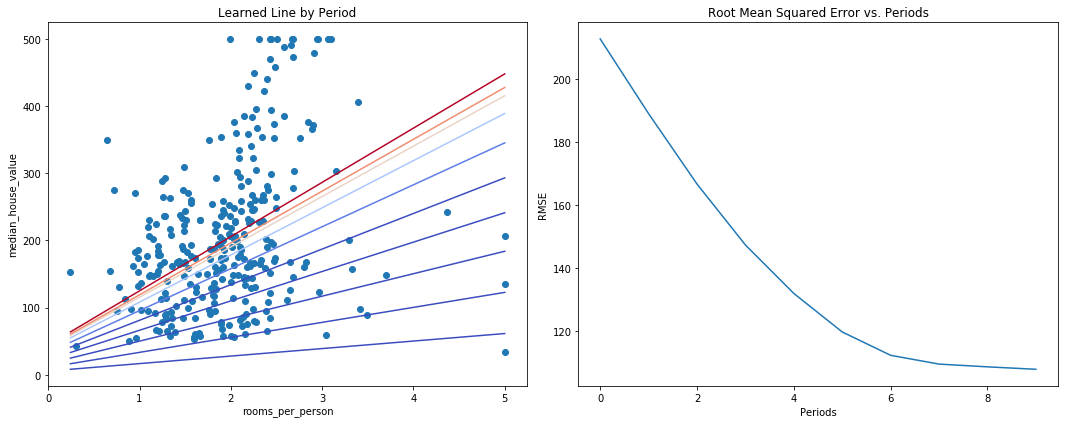

In [ ]:
# To verify that clipping worked, let's train again and print the calibration data once more:

calibration_data = train_model(
  learning_rate = 0.05,
  steps = 500,
  batch_size = 5,
  input_feature = 'rooms_per_person')

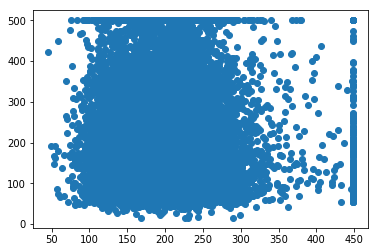

In [ ]:
_ = plt.scatter(calibration_data['predictions'], calibration_data['targets'])

## Use Validation Test

**Learning Objectives:**
  * Use multiple features, instead of a single feature, to further improve the effectiveness of a model
  * Debug issues in model input data
  * Use a test data set to check if a model is overfitting the validation data

In [ ]:
# Setup
# First off, let's load up and prepare our data. This time, we're going to work with multiple features, 
# so we'll modularize the logic for preprocessing the features a bit:

from __future__ import print_function

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import math

%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [ ]:
def preprocess_features(california_housing_dataframe):
  '''Prepares input features from California housing dataset
  
  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data 
    from the California housing data set
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  '''
  selected_features = california_housing_dataframe[
      ['latitude',
       'longitude',
       'housing_median_age',
       'total_rooms',
       'total_bedrooms',
       'population',
       'households',
       'median_income']]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features['rooms_per_person'] = (
    california_housing_dataframe['total_rooms'] /
    california_housing_dataframe['population'])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  '''Prepares target features (i.e., labels) from california housing dataset.
  
  ArgsL
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing dataset
  Returns:
    A DataFrame that contains the target feature
  '''
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets['median_house_value'] = (
    california_housing_dataframe['median_house_value'] / 1000.0)
  return output_targets

In [ ]:
# For the training set, we'll choose the first 12000 examples, out of the total of 17000.

training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2624.8,536.6,1420.8,498.7,3.9,2.0
std,2.1,2.0,12.6,2158.7,420.6,1155.8,384.5,1.9,1.1
min,32.5,-124.3,2.0,12.0,3.0,3.0,3.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,295.0,786.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2121.0,432.0,1164.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3137.2,646.0,1718.0,602.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [ ]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.7
std,115.5
min,15.0
25%,120.3
50%,181.3
75%,265.2
max,500.0


In [ ]:
# For the validation set, we'll choose the last 5000 examples, out of the total of 17000.

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2689.0,546.3,1450.6,507.3,3.9,2.0
std,2.1,2.0,12.6,2229.6,423.7,1128.3,384.6,1.9,1.4
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1478.0,300.0,794.0,284.0,2.6,1.5
50%,34.3,-118.5,28.0,2150.5,439.0,1177.0,413.0,3.5,2.0
75%,37.7,-118.0,37.0,3182.2,654.0,1733.2,612.2,4.7,2.3
max,42.0,-114.6,52.0,30405.0,4798.0,12873.0,4490.0,15.0,52.0


In [ ]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,206.4
std,117.0
min,15.0
25%,118.1
50%,178.2
75%,264.7
max,500.0


## Task 1: Examine the Data
Okay, let's look at the data above. We have `9` input features that we can use.

Take a quick skim over the table of values. Everything look okay? See how many issues you can spot. Don't worry if you don't have a background in statistics; common sense  will get you far.

Let's check our data against some baseline expectations:

* For some values, like `median_house_value`, we can check to see if these values fall within reasonable ranges (keeping in mind this was 1990 data — not today!).

* For other values, like `latitude` and `longitude`, we can do a quick check to see if these line up with expected values from a quick Google search.

If you look closely, you may see some oddities:

* `median_income` is on a scale from about 3 to 15. It's not at all clear what this scale refers to—looks like maybe some log scale? It's not documented anywhere; all we can assume is that higher values correspond to higher income.

* The maximum `median_house_value` is 500,001. This looks like an artificial cap of some kind.

* Our `rooms_per_person` feature is generally on a sane scale, with a 75th percentile value of about 2. But there are some very large values, like 18 or 55, which may show some amount of corruption in the data.

We'll use these features as given for now. But hopefully these kinds of examples can help to build a little intuition about how to check data that comes to you from an unknown source.

## Task 2: Plot Latitude/Longitude vs. Median House Value

Let's take a close look at two features in particular: **`latitude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization — let's plot `latitude` and `longitude`, and use color to show the `median_house_value`.

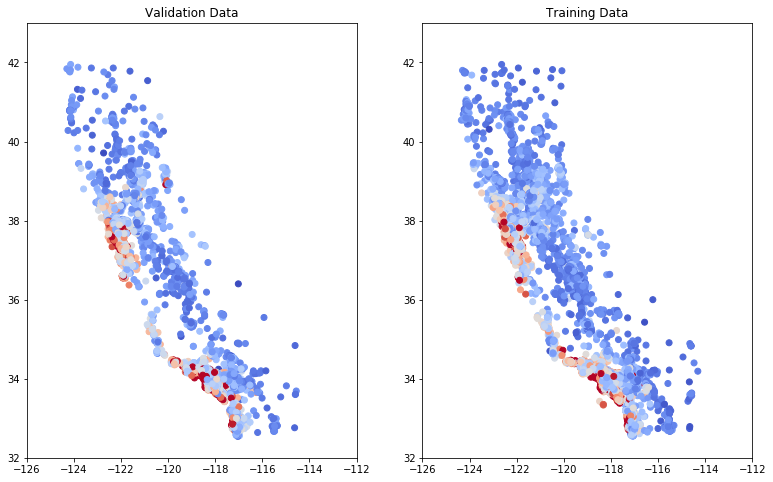

In [ ]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title('Validation Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples['longitude'],
           validation_examples['latitude'],
           cmap = 'coolwarm',
           c = validation_targets['median_house_value'] / validation_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title('Training Data')

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples['longitude'],
           training_examples['latitude'],
           cmap = 'coolwarm',
           c = training_targets['median_house_value'] / training_targets['median_house_value'].max())
_ = plt.plot()

Wait a second...this should have given us a nice map of the state of California, with red showing up in expensive areas like the San Francisco and Los Angeles.

The training set sort of does, compared to a [real map](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), but the validation set clearly doesn't.

**Go back up and look at the data from Task 1 again.**

Do you see any other differences in the distributions of features or targets between the training and validation data?

Looking at the tables of summary stats above, it's easy to wonder how anyone would do a useful data check. What's the right 75<sup>th</sup> percentile value for total_rooms per city block?

The key thing to notice is that for any given feature or column, the distribution of values between the train and validation splits should be roughly equal.

The fact that this is not the case is a real worry, and shows that we likely have a fault in the way that our train and validation split was created.

## Task 3:  Return to the Data Importing and Pre-Processing Code, and See if You Spot Any Bugs
If you do, go ahead and fix the bug. Don't spend more than a minute or two looking. If you can't find the bug, check the solution.

When you've found and fixed the issue, re-run `latitude` / `longitude` plotting cell above and confirm that our sanity checks look better.

By the way, there's an important lesson here.

**Debugging in ML is often *data debugging* rather than code debugging.**

If the data is wrong, even the most advanced ML code can't save things.

# Solution

The code that randomizes the data (np.random.permutation) is commented out, so we're not doing any randomization prior to splitting the data.

If we don't randomize the data properly before creating training and validation splits, then we may be in trouble if the data is given to us in some sorted order, which appears to be the case here.

## Task 4: Train and Evaluate a Model

**Spend 5 minutes or so trying different hyperparameter settings.  Try to get the best validation performance you can.**

Next, we'll train a linear regressor using all the features in the data set, and see how well we do.

Let's define the same input function we've used previously for loading the data into a TensorFlow model.


In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  '''Train a linear regression model of multiple features.
  
  Args:
    features: pandas DataFrame of features
    targets: pandas DataFrame of targets
    batch_size: Size of batches to be passed to the model
    shuffle: True or False. Whether to shuffle the data.
    num_epochs: Number of epochs for which data should be repeated. Non=repeat indefinetely
  Returns:
    Tuple of (features, labels) for next data batch
  '''
  
  # Convert pandas data into a dict of np arrays.
  features = {key:np.array(value) for key, value in dict(features).items()}
  
  # Construct a dataset, and configure batching/repeating.
  ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  # Shuffle the data, if specified
  if shuffle:
    ds = ds.shuffle(10000)
    
  # Return the next batch of data
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a separate function. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercises.)

In [ ]:
def construct_feature_columns(input_features):
  '''Construct the TensorFlow Feature Columns.
  
  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  '''
  return set([tf.feature_column.numeric_column(my_feature)
             for my_feature in input_features])

Next, go ahead and complete the `train_model()` code below to set up the input functions and calculate predictions.

**NOTE:** It's okay to reference the code from the previous exercises, but make sure to call `predict()` on the appropriate data sets.

Compare the losses on training data and validation data. With a single raw feature, our best root mean squared error (RMSE) was of about 180.

See how much better you can do now that we can use multiple features.

Check the data using some of the methods we've looked at before.  These might include:

   * Comparing distributions of predictions and actual target values

   * Creating a scatter plot of predictions vs. target values

   * Creating two scatter plots of validation data using `latitude` and `longitude`:
      * One plot mapping color to actual target `median_house_value`
      * A second plot mapping color to predicted `median_house_value` for side-by-side comparison.

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 217.71
  period 01 : 200.13
  period 02 : 186.07
  period 03 : 176.15
  period 04 : 170.37
  period 05 : 167.93
  period 06 : 166.82
  period 07 : 167.21
  period 08 : 167.61
  period 09 : 168.56
Model training finished.


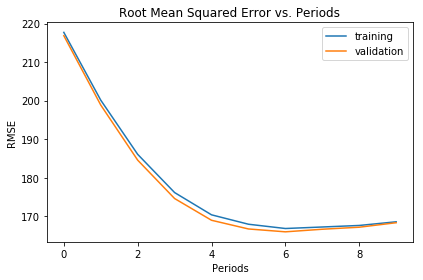

In [ ]:
Linear_regressor = train_model(
  learning_rate = 0.00003,
  steps = 500,
  batch_size = 5,
  training_examples = training_examples,
  training_targets = training_targets,
  validation_examples = validation_examples,
  validation_targets = validation_targets)

In [ ]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = Linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 161.92


## Frature Stes

**Learning Objective:** Create a minimal set of features that performs just as well as a more complex feature set

So far, we've thrown all of our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal set of housing features that will perform equally as well as one that uses all the features in the data set.

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [ ]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [ ]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.7,-119.6,28.7,2638.8,538.8,1428.3,500.2,3.9,2.0
std,2.1,2.0,12.6,2195.9,424.4,1173.4,386.8,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,297.0,790.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2127.0,432.0,1161.5,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3133.0,647.0,1705.0,602.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.4,2655.4,540.8,1432.5,503.7,3.9,2.0
std,2.1,2.0,12.5,2141.3,414.5,1084.2,379.0,1.9,1.1
min,32.6,-124.3,2.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.7,18.0,1463.0,296.0,788.0,281.0,2.6,1.5
50%,34.2,-118.5,28.0,2128.5,439.0,1185.5,412.0,3.6,1.9
75%,37.7,-118.0,37.0,3182.0,652.0,1765.0,610.0,4.8,2.3
max,41.9,-114.6,52.0,30405.0,4952.0,12873.0,4616.0,15.0,34.2


Training targets summary:


,median_house_value
count,12000.0
mean,206.6
std,115.6
min,15.0
25%,118.9
50%,179.2
75%,264.4
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,209.0
std,117.0
min,15.0
25%,121.0
50%,182.1
75%,266.4
max,500.0


## Task 1: Develop a Good Feature Set

**What's the best performance you can get with just 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to other features.

Here, correlation is defined as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).  You don't have to understand the mathematical details for this exercise.

Correlation values have the following meanings:

  * `-1.0`: perfect negative correlation
  * `0.0`: no correlation
  * `1.0`: perfect positive correlation

In [ ]:
correlation_dataframe = training_examples.copy()
correlation_dataframe['target'] = training_targets['median_house_value']

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.1,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.1,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Features that have strong positive or negative correlations with the target will add information to our model. We can use the correlation matrix to find such strongly correlated features.

We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

Use this information to try removing features.  You can also try developing additional synthetic features, such as ratios of two raw features.

For convenience, we've included the training code from the previous exercise.

In [ ]:
def construct_feature_columns(input_features):
  '''Construct the Tensorflow Feature Columns.
  
  Args:
    input_features:  The name of the numerical input features to use
  Returns:
    A set of feature columns
  '''
  return set([tf.feature_column.numeric_column(my_feature)
             for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 164.77
  period 01 : 125.38
  period 02 : 116.69
  period 03 : 116.32
  period 04 : 115.47
  period 05 : 117.03
  period 06 : 114.59
  period 07 : 114.19
  period 08 : 113.57
  period 09 : 112.92
Model training finished.


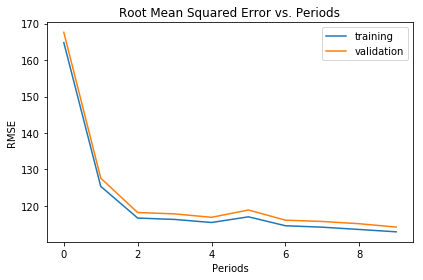

In [ ]:
minimal_features = [
    'median_income',
    'latitude',
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate = 0.01,
    steps = 500,
    batch_size = 5,
    training_examples = minimal_training_examples,
    training_targets = training_targets,
    validation_examples = minimal_validation_examples,
    validation_targets = validation_targets)

## Task 2: Make Better Use of Latitude

Plotting `latitude` vs. `median_house_value` shows that there really isn't a linear relationship there.

Instead, there are a couple of peaks, which roughly correspond to Los Angeles and San Francisco.

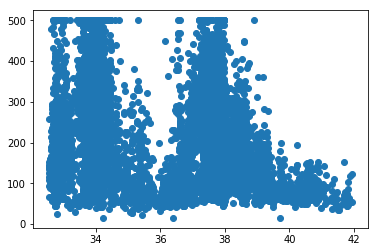

In [ ]:
plt.scatter(training_examples['latitude'], training_targets['median_house_value'])

**Try creating some synthetic features that do a better job with latitude.**

For example, you could have a feature that maps `latitude` to a value of `|latitude - 38|`, and call this `distance_from_san_francisco`.

Or you could break the space into 10 different buckets.  `latitude_32_to_33`, `latitude_33_to_34`, etc., each showing a value of `1.0` if `latitude` is within that bucket range and a value of `0.0` otherwise.

Use the correlation matrix to help guide development, and then add them to your model if you find something that looks good.

What's the best validation performance you can get?

Aside from `latitude`, we'll also keep `median_income`, to compare with the previous results.

We decided to bucketize the latitude. This is fairly straightforward in Pandas using `Series.apply`

In [ ]:
xnxxdef select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 226.46
  period 01 : 216.27
  period 02 : 206.21
  period 03 : 196.23
  period 04 : 186.37
  period 05 : 176.63
  period 06 : 167.04
  period 07 : 157.65
  period 08 : 148.51
  period 09 : 139.59
Model training finished.


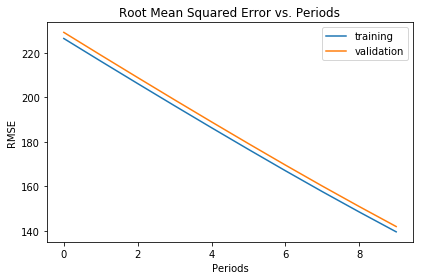

In [ ]:
_ = train_model(
    learning_rate = 0.01,
    steps = 500,
    batch_size = 5,
    training_examples = selected_training_examples,
    training_targets = training_targets,
    validation_examples = selected_validation_examples,
    validation_targets = validation_targets)

## Feature Crosses

**Learning Objectives:**
  * Improve a linear regression model with the addition of additional synthetic features (this is a continuation of the previous exercise)
  * Use an input function to convert pandas `DataFrame` objects to `Tensors` and invoke the input function in `fit()` and `predict()` operations
  * Use the FTRL optimization algorithm for model training
  * Create new synthetic features through one-hot encoding, binning, and feature crosses

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [ ]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [ ]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2651.2,540.4,1430.4,502.1,3.9,2.0
std,2.1,2.0,12.6,2200.8,425.0,1167.8,387.6,1.9,1.3
min,32.5,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1468.0,297.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,28.0,2124.0,433.0,1168.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3158.0,650.0,1714.0,606.0,4.8,2.3
max,42.0,-114.5,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.8,2625.5,536.9,1427.6,499.1,3.9,2.0
std,2.1,2.0,12.5,2129.1,413.0,1098.7,376.9,1.9,0.9
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1448.8,296.0,787.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2143.5,435.5,1161.5,411.0,3.5,1.9
75%,37.7,-118.0,37.0,3129.0,646.0,1747.0,603.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,16122.0,5189.0,15.0,29.4


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,116.1
min,15.0
25%,119.0
50%,179.8
75%,264.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.1
std,115.6
min,17.5
25%,120.6
50%,181.6
75%,265.7
max,500.0


In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## FTRL Optimization Algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 219.74
  period 01 : 146.17
  period 02 : 113.16
  period 03 : 122.16
  period 04 : 123.77
  period 05 : 122.83
  period 06 : 111.14
  period 07 : 127.10
  period 08 : 118.17
  period 09 : 128.90
Model training finished.


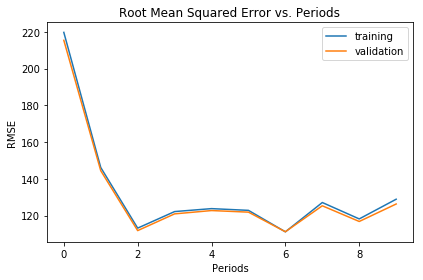

In [ ]:
_ = train_model(learning_rate = 1.0, steps = 500, batch_size = 100, 
               feature_columns = construct_feature_columns(training_examples),
               training_examples = training_examples,
               training_targets = training_targets,
               validation_examples = validation_examples,
               validation_targets = validation_targets)

## One-Hot Encoding for Discrete Features

Discrete (i.e. strings, enumerations, integers) features are usually converted into families of binary features before training a logistic regression model.

For example, suppose we created a synthetic feature that can take any of the values `0`, `1` or `2`, and that we have a few training points:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

For each possible categorical value, we make a new **binary** feature of **real values** that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |


## Bucketized (Binned) Features

Bucketization is also known as binning.

We can bucketize `population` into the following 3 buckets (for instance):
- `bucket_0` (`< 5000`): corresponding to less populated blocks
- `bucket_1` (`5000 - 25000`): corresponding to mid populated blocks
- `bucket_2` (`> 25000`): corresponding to highly populated blocks

Given the preceding bucket definitions, the following `population` vector:

    [[10001], [42004], [2500], [18000]]

becomes the following bucketized feature vector:

    [[1], [2], [0], [1]]

The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

To define feature columns for bucketized features, instead of using `numeric_column`, we can use [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column), which takes a numeric column as input and transforms it to a bucketized feature using the bucket boundaries specified in the `boundaries` argument. The following code defines bucketized feature columns for `households` and `longitude`; the `get_quantile_based_boundaries` function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

In [ ]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households inot 7 buckets
households = tf.feature_column.numeric_column('households')
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries = get_quantile_based_boundaries(
        california_housing_dataframe['households'], 7))

# Divide longitude into 10 buckets
longitude = tf.feature_column.numeric_column('longitude')
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries = get_quantile_based_boundaries(
    california_housing_dataframe['longitude'], 10))

## Task 1: Train the Model on Bucketized Feature Columns
**Bucketize all the real valued features in our example, train the model and see if the results improve.**

In the preceding code block, two real valued columns (namely `households` and `longitude`) have been transformed into bucketized feature columns. Your task is to bucketize the rest of the columns, then run the code to train the model. There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

You may be wondering how to determine how many buckets to use. That is of course data-dependent. Here, we just selected arbitrary values so as to obtain a not-too-large model.

In [ ]:
def construct_feature_columns():
  '''Construct the TensorFlow Feature Columns
  
  Returns
    A set of feature columns
  '''
  
  households = tf.feature_column.numeric_column('households')
  longitude = tf.feature_column.numeric_column('longitude')
  latitude = tf.feature_column.numeric_column('latitude')
  housing_median_age = tf.feature_column.numeric_column('housing_median_age')
  median_income = tf.feature_column.numeric_column('median_income')
  rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries = get_quantile_based_boundaries(
      training_examples['households'], 7))
  
  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries = get_quantile_based_boundaries(
      training_examples['longitude'], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries = get_quantile_based_boundaries(
      training_examples['latitude'], 10))
  
  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries = get_quantile_based_boundaries(
      training_examples['housing_median_age'], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries = get_quantile_based_boundaries(
      training_examples['median_income'], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries = get_quantile_based_boundaries(
      training_examples['rooms_per_person'], 7))
  
  feature_columns = set([
      bucketized_longitude,
      bucketized_latitude,
      bucketized_housing_median_age,
      bucketized_households,
      bucketized_median_income,
      bucketized_rooms_per_person])
  
  return feature_columns
  

Training model...
RMSE (on training data):
  period 00 : 169.47
  period 01 : 143.26
  period 02 : 126.84
  period 03 : 115.74
  period 04 : 107.85
  period 05 : 102.03
  period 06 : 97.48
  period 07 : 94.01
  period 08 : 91.07
  period 09 : 88.62
Model training finished.


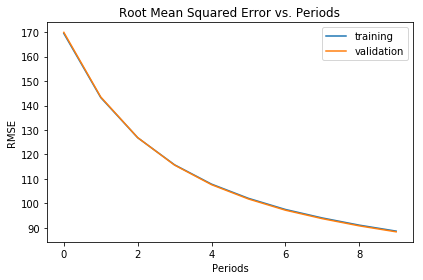

In [ ]:
_ = train_model(learning_rate = 1.0, steps = 500, batch_size = 100,
               feature_columns = construct_feature_columns(),
               training_examples = training_examples,
               training_targets = training_targets,
               validation_examples = validation_examples,
               validation_targets = validation_targets)

In [ ]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.38
  period 01 : 135.42
  period 02 : 118.50
  period 03 : 107.27
  period 04 : 99.34
  period 05 : 93.56
  period 06 : 89.13
  period 07 : 85.56
  period 08 : 82.66
  period 09 : 80.34
Model training finished.


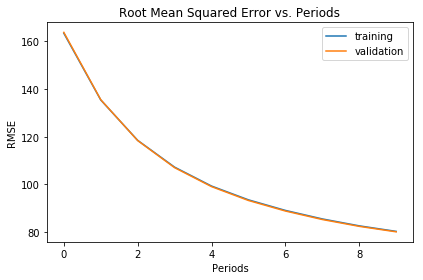

In [ ]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)